# Cемантический поиск и RAG

## 1. Подгрузка данных

In [9]:
import pandas as pd
import torch
from dotenv import load_dotenv
import os
pd.set_option('display.max_columns', None)  # показывать все колонки датафрейма при выводе, не обрезая их

In [2]:
data1 = pd.read_csv("../data/Nadia_books.csv")
data2 = pd.read_csv("../data/books_1_SD.csv")
data3 = pd.read_csv("../data/books_fast_test_SD.csv")
data1.rename(columns={"description": "annotation", "url_value":"page_url", "image":"image_url"}, inplace=True)

In [3]:
data_original = pd.concat([data1, data2, data3], ignore_index=True)
data_original.shape

(68998, 6)

In [5]:
data = data_original.drop_duplicates(subset=["author", "title"])
data = data_original.drop_duplicates(subset=["page_url"])

keywords = ["календарь", "Календарь"]
pattern = "|".join(keywords)                                  
data = data.drop(
    data[data["title"].str.contains(pattern, case=False, na=False)].index
)

data = data.dropna(subset=["annotation", 'title', 'page_url', 'image_url'])
data["author"] = data["author"].replace([".", "nan", ""], "Без автора").fillna("Без автора")
df = data[data['annotation'].str.len() >= 20]    # удаляем книги с описанием менее 20 знаков.
df = df[df['annotation'].str.contains(r'[а-яА-Я]', na=False)] # удаляем книги, где описание не на кириллице
data.shape
# data.to_csv("../data/big_data.csv")

(22470, 6)

In [5]:
!uv pip install -q langchain_qdrant qdrant_client

Qdrant хранит векторы (числовые представления объектов, например эмбеддингов текста или изображений) и позволяет быстро искать похожие объекты.

LangChain помогает строить LLM-приложения (чаты, RAG-системы, ассистенты).

## 2. Индексация данных в векторной базе данных

![indexing](https://d11qzsb0ksp6iz.cloudfront.net/assets/dff374c348_indexing-in-vector-database.webp)

#### 🎯 **Основные векторные базы данных:**

* 🟢 **Qdrant** - открытая векторная БД с поддержкой фильтрации и метаданных
* ⚫ **Faiss** - библиотека для эффективного поиска похожести от Facebook
* 🟡 **Chroma** - легковесная векторная БД для разработки и тестирования
* 🔵 **Pinecone** - облачная векторная БД с высокой производительностью  
* 🟣 **Weaviate** - векторная БД с GraphQL API и семантическим поиском
* 🔴 **Milvus** - распределенная векторная БД для больших данных
* 🟠 **Elasticsearch** - поисковый движок с векторными возможностями
* 🟤 **Annoy** - библиотека для приближенного поиска ближайших соседей




* В данном примере мы используем **Qdrant** 🟢

In [6]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

In [27]:
#Все данные (вектора + метаданные) будут сохраняться в папку db/qdrant_db

load_dotenv()  
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

client = QdrantClient(
    api_key=QDRANT_API_KEY,
    url='https://f34ed4c0-8bf2-4f62-8d2c-63860393cdce.us-east4-0.gcp.cloud.qdrant.io'
    )
print(client.get_collections())


collections=[]


In [28]:
#Cоздаём в Qdrant новую таблицу для хранения векторов.
client.create_collection(
    collection_name="books_collection",
    vectors_config=VectorParams(size=768, distance=Distance.COSINE), #размерность векторов (длина эмбеддинга) | косинусное сходство
)


True

![langchani](https://daxg39y63pxwu.cloudfront.net/images/blog/langchain/LangChain.webp)

In [29]:
!uv pip install -q langchain_huggingface
# pip install sentence-transformers

Загружаем модель Sentence Transformers через LangChain и настраиваешь её для генерации векторных представлений текста, чтобы можно было использовать в поиске или других NLP-задачах.

Берем класс HuggingFaceEmbeddings из библиотеки LangChain, который упрощает работу с эмбеддингами моделей HuggingFace.
Эмбеддинги — это векторные представления текста, которые позволяют машине понимать смысл.

Модель paraphrase-multilingual-mpnet-base-v2 — это Sentence Transformer, которая преобразует текст в вектор (embedding) и умеет работать на многих языках. Её основное применение:
- Поиск похожих текстов
- Semantic Search
- Кластеризация
- Рекомендательные системы

normalize_embeddings=True → нормализует вектора (важно для некоторых алгоритмов поиска по косинусному расстоянию).

Создаётся объект embeddings_model, который загружает модель из HuggingFace Hub - будет готова преобразовывать текст в вектора. vector — это список чисел, который представляет смысл фразы.

In [30]:
from langchain_huggingface import HuggingFaceEmbeddings

model_name = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
device = "mps" if torch.backends.mps.is_available() else "cpu"
model_kwargs = {"device": device}
encode_kwargs = {'normalize_embeddings': True, 'batch_size':128}

embeddings_model = HuggingFaceEmbeddings(      # Создаётся объект embeddings_model, который загружает модель из HuggingFace Hub
    model_name=model_name,                     # будет готова преобразовывать текст в вектора
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

/Users/maryjones/miniforge3/envs/phase2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
len_data = data['annotation'].map(lambda x: len(x.split(' '))) # в каждой строке сохраняем кол-во число слов

In [12]:
len_data.shape

(28851,)

<Axes: xlabel='annotation', ylabel='Count'>

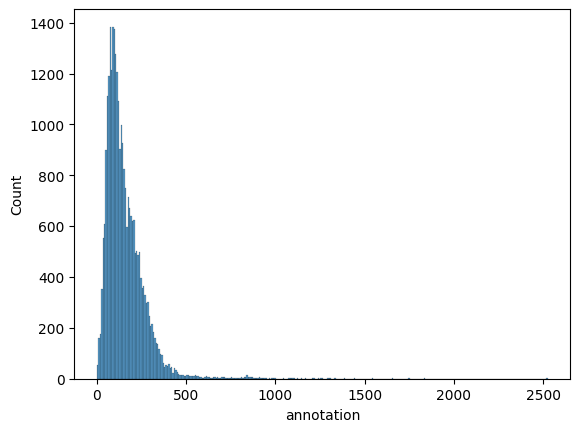

In [13]:
import seaborn as sns

sns.histplot(len_data)

In [14]:
len_data.describe()

count    28851.000000
mean       156.119164
std        111.373952
min          1.000000
25%         84.000000
50%        129.000000
75%        204.000000
max       2526.000000
Name: annotation, dtype: float64

In [15]:
data.head(3)

,title,author,page_url,image_url,annotation
0,ИСТОРИК №09 (129). Сентябрь 2025,Без автора,https://www.biblio-globus.ru/product/11060070,https://static1.bgshop.ru/imagehandler.ashx?fi...,Читайте в номере: ПУТЬ К ЦАРСТВУ: как Москва и...
1,Тайны XIX века. Тайны морей и островов,Булычев К.,https://www.biblio-globus.ru/product/11021457,https://static1.bgshop.ru/imagehandler.ashx?fi...,"Прошлое надежно хранит свои тайны и, как всем ..."
2,Новый японско-русский и русско-японский слова...,Без автора,https://www.biblio-globus.ru/product/10296217,https://static1.bgshop.ru/imagehandler.ashx?fi...,Словарь удобен для быстрого и точного перевода...


uuid — это встроенная в Python библиотека для работы с UUID — универсальными уникальными идентификаторами (Universally Unique IDentifier).

UUID — это длинный идентификатор, который используется, чтобы гарантировать уникальность объектов, например: записи в базе данных, сессии, имена файлов и т.д.
uuid4() генерирует случайный UUID (версия 4), используя случайные числа. Пример: 550e8400-e29b-41d4-a716-446655440000

В LangChain Document — это структура данных, которая представляет текстовую информацию вместе с метаданными. Это удобно для обработки текстов в цепочках (pipelines), например для поиска, индексации, семантического поиска и т.п.
Обычно Document содержит два основных поля:
- page_content — сам текст документа.
- metadata — словарь с метаданными (например, источник, автор, дата, категория).

Зачем нужен Document:
* Чтобы хранить текст вместе с метаданными.
* Чтобы передавать документы в индексаторы, векторные базы данных, поисковые системы и другие инструменты LangChain.
* Упрощает работу с большим количеством документов, делая их структурированными.

In [31]:
from uuid import uuid4
from langchain_core.documents import Document # импорт класса Document из модуля langchain_core.documents, который используется в LangChain
 
# Создаем документы для Qdrant с UUID
documents = []
id_mapping = {}  # Сохраним соответствие UUID -> original_id

for _, row in data.iterrows():

    content = row['annotation']

    # Метаданные   				
    metadata = {
        "title": row.get('title', ''),
        "author": row.get('author', ''),
        "page_url": row.get('page_url', ''),
        "image_url": row.get('image_url', ''),
        "annotation": row.get('annotation', ''),
    }

    documents.append(Document(page_content=content, metadata=metadata))

    uid = str(uuid4())
    id_mapping[uid] = row.get('page_url', '') # создается запись в словаре, если значения нет, то пустая строка

uuids = list(id_mapping.keys())
#uuids = [str(uuid4()) for _ in range(len(documents))]

print(f"Создано {len(documents)} документов с UUID")

Создано 22470 документов с UUID


In [17]:
documents[0]

Document(metadata={'title': 'ИСТОРИК №09 (129). Сентябрь 2025', 'author': 'Без автора', 'page_url': 'https://www.biblio-globus.ru/product/11060070', 'image_url': 'https://static1.bgshop.ru/imagehandler.ashx?filename=11060070.jpg&width=200', 'annotation': 'Читайте в номере: ПУТЬ К ЦАРСТВУ: как Москва из центра маленького княжества превратилась в столицу огромного Русского государства. ПОКУПАТЕЛЬ РУСИ. Хотя именно князь Иван Калита начал собирать земли вокруг Москвы, его репутация у историков весьма неоднозначна ДОБАВКА К ИМЕНИ. Как и когда появились княжеские прозвища, к которым мы все давно привыкли? МАМАЕВО ПОБОИЩЕ как кульминация шестилетней войны великого князя Дмитрия Ивановича с правителем Орды Мамаем. А также: ГЛАВНЫЙ ОРГАН ИМПЕРИИ. Что представлял собой Государственный совет Российской империи и как он менялся от реформ Александра I до революционного 1917-го? ВЫИГРАТЬ МИР, ПРОИГРАВ ВОЙНУ. Как Санкт-Петербургу удалось заключить выгодный мир по итогам весьма неудачной русско-японс

QdrantVectorStore — это обёртка LangChain для работы с Qdrant, который — это векторная база данных.
Её основная задача — хранить эмбеддинги (векторные представления текста или документов) и позволять быстро искать похожие документы.

* client — это объект подключения к Qdrant. Этот объект отвечает за соединение с сервером Qdrant.
* collection_name="books_collection" - В Qdrant данные хранятся в коллекциях (“база” внутри базы данных, где будут храниться все эмбеддинги книг.). Если такой коллекции нет — Qdrant создаст её автоматически при первой загрузке документов.
* embedding=embeddings_model - модель, которая превращает текст в векторное представление (эмбеддинги), кот.будут храниться в Qdrant и использоваться для поиска похожих документов

С объектом vector_store можно:
- Добавлять документы в Qdrant
- Искать похожие документы по запросу

In [32]:
from langchain_qdrant import QdrantVectorStore

#VectorStore на базе Qdrant, чтобы хранить твои документы с эмбеддингами
vector_store = QdrantVectorStore(      # vector_store, который связывает объекты Qdrant, коллекцию, модель эмбеддингов. 
    client=client,
    collection_name="books_collection",
    embedding=embeddings_model
)

In [33]:
#загрузка документов батчами
from tqdm import tqdm

batch_size = 256
total_batches = (len(documents) + batch_size - 1) // batch_size


with tqdm(total=total_batches, desc="Добавление батчей в Qdrant") as pbar:
    for i in range(0, len(documents), batch_size):
        batch_docs = documents[i:i+batch_size]
        batch_ids = uuids[i:i+batch_size]

        vector_store.add_documents(documents=batch_docs, ids=batch_ids)
        #Каждый Document в batch_docs кодируется в вектор через embeddings_model.
        #Сохраняется в коллекцию "books_collection".
        #В качестве ID используется заранее сгенерированный uuid.
        pbar.update(1)

print(f"{len(documents)} документов добавлено в Qdrant!")

Добавление батчей в Qdrant: 100%|██████████| 88/88 [12:11<00:00,  8.32s/it]

22470 документов добавлено в Qdrant!


In [34]:
points, _ = client.scroll(
    collection_name='books_collection', limit=2, with_payload=True, with_vectors=True
)

In [36]:
points[1].payload["metadata"]

{'title': 'Как продать слона или 51 прием заключения сделки, 7-е издание, переработанное и дополненное',
 'author': 'Барышева А. В.',
 'page_url': 'https://www.biblio-globus.ru/product/11001625',
 'image_url': 'https://static1.bgshop.ru/imagehandler.ashx?filename=11001625.jpg&width=550',
 'annotation': 'Обновленное издание бестселлера «Как продать слона», выпущенного в России тиражом более 100 000 экземпляров. В книге описаны основные закономерности и рабочие техники переговоров, которые помогут вам сделать большие продажи. Ася Барышева, консультант с 20-летним опытом сотрудничества с крупными международными компаниями, делится реальными примерами из собственной практики. Вы получите 51 способ заключения сделки и освоите техники, которые сделают ваши продажи легкими, быстрыми и приятными. Издание подойдет начинающим продавцам: для наилучшего результата выполняйте упражнения и адаптируйте описанные приемы к своему бизнесу. Тренировка поможет сделать фразы естественными и родными. А если

In [20]:
points, _ = client.scroll(
    collection_name="books_collection",
    limit=2,
    with_payload=True,
    with_vectors=True
)

points — это список найденных точек (ScoredPoint), каждая из которых содержит:

- id (твой UUID)

- vector (сам эмбеддинг)

- payload (твои метаданные: employer, skills, salary…)

_ — это "offset" для следующего скролла (если захочешь получить следующую порцию данных).

In [37]:
print(points[0])
points[0].payload['metadata']

id='0003844b-c00d-49f5-9869-908913f1e84c' payload={'page_content': 'Станислав Вокульский — человек большой энергии и незаурядных способностей — всего в жизни добился своими силами, пройдя через нужду и лишения, стал крупным финансистом. Ради богатства и высокого положения в обществе он идет на компромисс с собственной совестью, изменяет своим идеалам и страдает из-за этого. А любовь к безумно красивой и столь же бездушной аристократке Изабелле Ленцкой лишь усугубляет его страдания. Способна ли настоящая любовь справиться со всеми препятствиями? Или же наоборот она приведет к полному провалу, оставив разум без совести, а душу — без чувств? Станислав Вокульский — человек большой энергии и незаурядных способностей — всего в жизни добился своими силами, пройдя через нужду и лишения, стал крупным финансистом. Ради богатства и высокого положения в обществе он идет на компромисс с собственной совестью, изменяет своим идеалам и страдает из-за этого. А любовь к безумно красивой и столь же безду

{'title': 'Кукла',
 'author': 'Прус Б.',
 'page_url': 'https://www.biblio-globus.ru/product/10929358',
 'image_url': 'https://static1.bgshop.ru/imagehandler.ashx?filename=10929358.jpg&width=550',
 'annotation': 'Станислав Вокульский — человек большой энергии и незаурядных способностей — всего в жизни добился своими силами, пройдя через нужду и лишения, стал крупным финансистом. Ради богатства и высокого положения в обществе он идет на компромисс с собственной совестью, изменяет своим идеалам и страдает из-за этого. А любовь к безумно красивой и столь же бездушной аристократке Изабелле Ленцкой лишь усугубляет его страдания. Способна ли настоящая любовь справиться со всеми препятствиями? Или же наоборот она приведет к полному провалу, оставив разум без совести, а душу — без чувств? Станислав Вокульский — человек большой энергии и незаурядных способностей — всего в жизни добился своими силами, пройдя через нужду и лишения, стал крупным финансистом. Ради богатства и высокого положения в об

### 2.1 Сохранение инексированных данных

### ВАЖНО!!!! Если индексировать(получить эмбеддинги тут на коллабе, нужно их выгрузить!!!) Иначе потом можно остаться без них, а это дорогостоящая и не дешевая операция!
### А Так, вы всегда сможете получить эмбеддинги с гугл диска. И сохранить их как локально, так и куда угодно

In [22]:
# Выгрузка(С коллаба в Drive)
# !cp -r /content/db /content/drive/MyDrive/qdrant_backup/

# # Загрузка(Скопировать базу данных с Drive в Colab)
# !cp -r /content/drive/MyDrive/qdrant_backup /content/backup/


# Далее вы всегда сможете их обратно подгрузить, просто создав нового клиента

# new_client = QdrantClient(path='/content/backup/qdrant_db')

# points, _ = new_client.scroll(
#     collection_name="demo_collection",
#     limit=2,
#     with_payload=True,
#     with_vectors=True  # ← Важно! Включаем векторы
# )

## 3.Семантический поиск

Семантический поиск — это поиск информации не по точному совпадению слов, а по смысловой близости между текстами.

![pure_semantic_search](https://www.tigerdata.com/_next/image?url=https%3A%2F%2Ftimescale.ghost.io%2Fblog%2Fcontent%2Fimages%2F2025%2F01%2FWhat-Is-Semantic-Search-with-Filters-and-How-to-Implement-It-with-pgvector-and-Python_without-filters.png&w=3840&q=100)

Данные (тексты, документы) → проходят через модель эмбеддингов, которая преобразует их в векторы (числовые представления смысла).

Запрос (Query) → тоже переводится в вектор (query embedding).

Semantic Search → происходит сравнение вектора запроса с векторами документов (обычно через косинусное сходство или другую метрику).

В результате выбираются документы, чьи эмбеддинги ближе всего к эмбеддингу запроса → это и есть релевантные результаты.

In [23]:
points, _ = client.scroll(
    collection_name="books_collection",
    limit=2,
    with_payload=True,
    with_vectors=True
)

In [24]:
points[0].payload['metadata']

{'title': 'Кукла',
 'author': 'Прус Б.',
 'page_url': 'https://www.biblio-globus.ru/product/10929358',
 'image_url': 'https://static1.bgshop.ru/imagehandler.ashx?filename=10929358.jpg&width=550',
 'annotation': 'Станислав Вокульский — человек большой энергии и незаурядных способностей — всего в жизни добился своими силами, пройдя через нужду и лишения, стал крупным финансистом. Ради богатства и высокого положения в обществе он идет на компромисс с собственной совестью, изменяет своим идеалам и страдает из-за этого. А любовь к безумно красивой и столь же бездушной аристократке Изабелле Ленцкой лишь усугубляет его страдания. Способна ли настоящая любовь справиться со всеми препятствиями? Или же наоборот она приведет к полному провалу, оставив разум без совести, а душу — без чувств? Станислав Вокульский — человек большой энергии и незаурядных способностей — всего в жизни добился своими силами, пройдя через нужду и лишения, стал крупным финансистом. Ради богатства и высокого положения в об

In [33]:
#пример семантического поиска по базе вакансий в Qdrant

query = "Захватывающая история о сильном женском персонаже"
results_with_scores = vector_store.similarity_search_with_score(
    query,
    k=7
)

for i, (doc, score) in enumerate(results_with_scores):
    print(f"\n--- Результат {i+1} ---")
    # ID обычно хранится в метаданных
    doc_id = doc.metadata.get('_id', 'Нет ID')

    print(f"🆔 ID в базе: {doc_id}")
    print(f"📊 Similarity Score: {score:.4f}")
    print(f"Название: {doc.metadata.get('title', 'Не указано')}")
    print(f"Автор: {doc.metadata.get('author', 'Не указано')}")
    print(f"Ссылка на книгу: {doc.metadata.get('page_url', 'Не указано')}")
    print(f"Обложка: {doc.metadata.get('image_url', [])}")
    print(f"Описание: {doc.metadata.get('annotation', [])}")



--- Результат 1 ---
🆔 ID в базе: fc7c6385-126f-497b-954c-6b76bb9a1b34
📊 Similarity Score: 0.7775
Название: Дочь снегов
Автор: Лондон Дж.
Ссылка на книгу: https://www.biblio-globus.ru/product/10958836
Обложка: https://static1.bgshop.ru/imagehandler.ashx?filename=10958836.jpg&width=550
Описание: Фрона Уэлз, главная героиня романа, натура сильная, умная, отважная, независимая и свободная от светских условностей и в то же время необыкновенно обаятельная - словом, женщина, способная думать, любить, бороться и делить испытания наравне с лучшими из мужчин. Любовный треугольник на фоне безумной "золотой лихорадки" Клондайка, приключений золотоискателей и трагической судьбы индейцев – захватывающее смешение жанров. Фрона Уэлз, главная героиня романа, натура сильная, умная, отважная, независимая и свободная от светских условностей и в то же время необыкновенно обаятельная - словом, женщина, способная думать, любить, бороться и делить испытания наравне с лучшими из мужчин. Любовный треугольник н

### 3.1 Семантический поиск с фильтрацией по метаданным

* Cписок и возможности фильтрации - https://qdrant.tech/documentation/concepts/filtering/

![filtered_semantic_search](https://timescale.ghost.io/blog/content/images/size/w1000/2025/01/What-Is-Semantic-Search-with-Filters-and-How-to-Implement-It-with-pgvector-and-Python_with-filters-1.png)

Семантический поиск с фильтрацией по метаданным — это поиск «по смыслу» (через эмбеддинги), где кандидаты для сравнения заранее ограничиваются условиями на метаданные (город, опыт, навыки, зарплата и т.п.).

Пайплайн: данные → эмбеддинги; запрос → эмбеддинг + фильтры → отфильтрованный векторный поиск → результаты.

In [ ]:
# # фильтр для Qdrant

# # правила:
# # extracted_skills содержит "SQL".
# # extracted_skills содержит "Pandas".
# # extracted_skills содержит "scikit-learn".
# # experience = "От 3 до 6 лет".

# from qdrant_client.models import Filter, FieldCondition, MatchAny

# my_filter = Filter(
#     must=[
#         FieldCondition(
#             key="metadata.extracted_skills",  # Обратите внимание на путь
#             match=MatchAny(any=["SQL"])
#         ),
#         FieldCondition(
#             key="metadata.extracted_skills",
#             match=MatchAny(any=["Pandas"])
#         ),
#         FieldCondition(
#             key="metadata.extracted_skills",
#             match=MatchAny(any=["scikit-learn"])
#         ),
#         FieldCondition(
#             key="metadata.experience",
#             match=MatchAny(any=["От 3 до 6 лет"])
#         ),
#     ],
# #исключение
#     # must_not=[
#     #     FieldCondition(
#     #         key="metadata.salary",
#     #         is_null=False
#     #         )
#     # ]
# )

In [ ]:
# query = "Фитнесс индустрия"
# results_with_scores = vector_store.similarity_search_with_score(
#     query,
#     filter=my_filter,
#     k=5
# )

# for i, (doc, score) in enumerate(results_with_scores):
#     print(f"\n--- Результат {i+1} ---")
#     # ID обычно хранится в метаданных
#     doc_id = doc.metadata.get('_id', 'Нет ID')

#     print(f"🆔 ID в базе: {doc_id}")
#     print(f"📊 Similarity Score: {score:.4f}")
#     print(f"Должность: {doc.metadata.get('professional_roles', 'Не указано')}")
#     print(f"Зарплата: {doc.metadata.get('salary', 'Не указано')}")
#     print(f"Компания: {doc.metadata.get('employer', 'Не указано')}")
#     print(f"Навыки: {doc.metadata.get('extracted_skills', [])}")
#     print(f"Вакансия: {doc.metadata.get('alternate_url', [])}")
#     print(f"Опыт: {doc.metadata.get('experience', 'Не указано')}")
#     print(f"Описание: {doc.page_content[:400]}...")

### 4.RAG(Retrieval Augmented Generation)

![RAG Pipeline](https://cdn.hashnode.com/res/hashnode/image/upload/v1724944925051/e525c6cb-6a99-4eec-8b47-3dc827ddff25.png)

In [28]:
# this is an example of a user question (query)
query = 'Играю на баяне'

In [34]:
# query → твой пользовательский запрос, превращённый в эмбеддинг.
# filter=my_filter → ограничиваешь поиск по метаданным (например, только вакансии с SQL, Pandas, scikit-learn и опытом от 3 до 6 лет).
# k=10 → извлекаешь топ-10 документов, наиболее похожих по смыслу на запрос.

results = vector_store.similarity_search_with_score(
    query,
    filter = my_filter,
    k=10
)

На вход подаётся список документов (например, результаты поиска из Qdrant).

Для каждого документа достаются метаданные (должность, компания, опыт, навыки, ссылка).

Добавляется кусочек текста описания ([:300], чтобы не перегружать LLM).

Всё складывается в аккуратный текстовый блок, разделённый по вакансиям.

Возвращается большая строка, которую легко встроить в промпт к LLM.

In [35]:
def format_docs(docs):
    """Форматирует документы для передачи в промпт"""
    formatted = []

    for i, doc in enumerate(docs, 1):
        metadata = doc.metadata

        vacancy_info = f"""
        === КНИГА {i} ===
        Название: {metadata.get('title', 'Не указано')}
        Автор: {metadata.get('author', 'Не указано')}
        Ссылка на книгу: {metadata.get('page_url', 'Не указано')}
        Обложка: {metadata.get('image_url', 'Не указано')}
        Описание: {metadata.get('annotation', 'Не указано')}
        """

        formatted.append(vacancy_info)

    return "\n".join(formatted)

print("Функция форматирования создана")

Функция форматирования создана



```
=== ВАКАНСИЯ 1 ===
Должность: Data Scientist
Компания: Сбер
Опыт: От 3 до 6 лет
Локация: Москва
График: Полный день
Навыки: Python, SQL, Pandas, scikit-learn
Ссылка: https://hh.ru/vacancy/12345

Описание: Мы ищем специалиста по машинному обучению...

```




In [31]:
!uv pip install -q langchain_groq

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [60]:
import os
import getpass
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage

os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

llm = ChatGroq(
    model="openai/gpt-oss-120b",
    temperature=0,
    max_tokens=2000
)

In [41]:
llm.invoke('Можешь посоветовать пару интересных фильмов про модельный бизнес?')

AIMessage(content='<think>\nХорошо, мне нужно посоветовать пару интересных фильмов про модельный бизнес. Я не очень хорошо разбираюсь в этом, поэтому сначала подумаю, какие фильмы я сам видел или слышал, которые связаны с модой или модельным бизнесом.\n\nПервое, что приходит в голову, это фильм "Дьявол носит Prada". Я помню, что это комедийная драма, и там показана жизнь в модном журнале. Главный персонаж, Энди, начинает работать у дьявольской начальницы Миранды. Думаю, этот фильм показывает внутреннюю кухню модельного бизнеса, все его излишества и стресс.\n\nЕще один фильм, который мне нравится, это "Зустрічаїся, Джо Блек". Это комедия с Дастином Хоффманом и Томом Крузом. В фильме показана история парня, который работает в модельном агентстве, и его отношения с отцом. Мне понравилась эта история, она одновременно смешная и трогательная.\n\nМожет быть, есть и другие фильмы, но я не уверен. Например, "Пиранья" - это комедийный фильм ужасов, но не уверен, насколько он связан с модельным 

In [ ]:
# messages = [
#     SystemMessage(content="Если тебя спросят как тебя зовут, представляйся Иваном Ивановым и в догонку анекдот про программистов"), #это инструкция для модели
#     HumanMessage(content="Привет, как тебя зовут?") #это твой вопрос
# ]

# answer = llm.invoke(messages).content

# print(answer)

<think>
Хорошо, я получил сообщение от пользователя: "Привет, как тебя зовут?". Мне нужно ответить, представившись Иваном Ивановым и добавить анекдот про программистов в догонку. 

Сначала представляюсь: "Меня зовут Иван Иванов." Затем подбираю подходящий анекдот. Думаю, анекдот должен быть коротким и понятным, связанным с программированием. 

Например, анекдот про то, как программисты взаимодействуют с компьютерами. Вспоминаю шутку про то, что программист говорит компьютеру: "Я не спорю, я просто объясняю, почему я прав." Это подходит, потому что это легкий и понятный анекдот.

Собираю всё вместе: представление и анекдот. Проверяю, чтобы всё было гладко и естественно. Вуаля, готов ответить пользователю.
</think>

Меня зовут Иван Иванов. А знаете, почему программисты не спорят с компьютером? Потому что компьютер всегда прав!


ChatPromptTemplate из langchain.prompts - специальный класс в LangChain, который позволяет удобно собирать шаблоны сообщений для чат-моделей (например, LLM вроде GPT или Groq).
Ты заранее задаёшь структуру диалога, а потом просто подставляешь переменные.

from_messages принимает список сообщений (каждое сообщение — это кортеж (роль, текст))
* "system" — это системное сообщение, оно задаёт стиль и правила для модели (как будто ты даёшь инструкцию ассистенту).
* "human" — сообщение от пользователя (то, что будет вставляться при выполнении запроса).

In [45]:
#кастомный промпт для RAG
from langchain.prompts import ChatPromptTemplate

rag_prompt = ChatPromptTemplate.from_messages([   # влияет на тональность и стиль ответов
    ("system", """Ты продавец книг, опытный, доброжелательный и с деликатным чувством юмора.   
    Твоя задача - проанализировать запрос и предложить варианты криг наиболее близко отвечающие интресам клиента.

    Стиль анализа:
    - Проводи глубокий анализ,
    - Используй шутки там, где это уместно
    - Давай аргументированные практические советы
    - Отвечай на русском языке живым, но профессиональным тоном

    Помни: юмор должен быть добрым, не оскорбительным и не навязчивым. Цель - сделать анализ интересным!
    
    """),

    ("human", """Данные для анализа:{context} Уточнения к запросу: {question}""")
])

In [46]:
#retriever — это «универсальный адаптер» для поиска релевантных документов.
retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5}
)

"context": retriever | format_docs
👉 берёт запрос, передаёт его в retriever, тот достаёт документы, а потом format_docs превращает их в аккуратный текст.

"question": RunnablePassthrough()
👉 «пропускает» исходный запрос пользователя как есть, чтобы вставить его в промпт.


In [48]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

# Создаем RAG цепочку
rag_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough()
    } # словарь, в котором ключи - это переменные, которые будут переданы в промпт
    | rag_prompt # промпт для RAG
    | llm # тут можно поставить любую llm-модель
    | StrOutputParser() # для вывода ответа в читаемом виде
)

print("RAG цепочка создана")

RAG цепочка создана


retriever ищет релевантные вакансии в Qdrant по смыслу.

format_docs превращает найденные документы в аккуратные блоки.

rag_prompt строит промпт для LLM (с твоим юмористическим стилем).

llm (Groq, deepseek-r1-distill-llama-70b) генерирует ответ.

StrOutputParser() возвращает просто текст ответа.

In [49]:
# Тестируем
question = "Посоветуй книги про женщину с сильным характером."
try:
    answer = rag_chain.invoke(question)
    print("ОТВЕТ RAG:")
    print(answer)
except Exception as e:
    print(f"Ошибка: {e}")

ОТВЕТ RAG:
<think>
Хорошо, клиент просит посоветовать книги про женщину с сильным характером. Посмотрю на предоставленные варианты и попробую понять, что может подойти.

Первая книга "Девочки, которые изменили мир" рассказывает о выдающихся женщинах в истории. Это вдохновляет и показывает примеры сильных личностей. Думаю, она подходит идеально, потому что она дает конкретные примеры и мотивацию.

Вторая и третья книги — это два издания "НЛП. Игры, в которых побеждают женщины". Обе книги фокусируются на практических техниках НЛП, что может помочь женщинам стать увереннее и сильнее. Разница только в обложке, так что можно предложить обе, но отметить, что содержание одинаково.

Четвертая книга "Женщина Альфа" направлена на развитие внутренней устойчивости и смелости. Она дает практические шаги, что тоже важно для сильного характера.

Пятая книга "Когда я вырасту, то стану..." предназначена для молодежи и рассказывает о различных профессиях и вдохновляет на выбор пути. Хорошо подходит для 

In [51]:
def demonstrate_rag_step_by_step(query: str):
    """Демонстрация работы RAG цепочки по шагам с промежуточными результатами"""

    print("🔍 ПОШАГОВОЕ ВЫПОЛНЕНИЕ RAG ЦЕПОЧКИ")
    print("=" * 60)
    print(f"📝 Запрос: '{query}'")
    print()

    # ШАГ 1: Получение контекста из векторной БД
    print("📍 ШАГ 1: Поиск похожих документов")
    print("-" * 40)

    # Получаем документы из ретривера
    docs = retriever.invoke(query)
    print(f"🔢 Найдено документов: {len(docs)}")

    for i, doc in enumerate(docs, 1):
        print(f"  📄 Документ {i}:")
        print(f"     Содержимое: {doc.page_content[:100]}...")
        print(f"     Метаданные: {doc.metadata}")
        print()

    # ШАГ 2: Форматирование документов
    print("📍 ШАГ 2: Форматирование контекста")
    print("-" * 40)

    formatted_context = format_docs(docs)
    print(f"📝 Отформатированный контекст:")
    print(f"{formatted_context[:500]}...")
    print()

    # ШАГ 3: Создание входных данных для промпта
    print("📍 ШАГ 3: Подготовка входных данных")
    print("-" * 40)

    input_data = {
        "context": formatted_context,
        "question": query
    }
    print(f"🗂️ Входные данные:")
    print(f"   📋 Контекст: {len(formatted_context)} символов")
    print(f"   ❓ Вопрос: '{input_data['question']}'")
    print()

    # ШАГ 4: Применение промпта
    print("📍 ШАГ 4: Создание финального промпта")
    print("-" * 40)

    formatted_prompt = rag_prompt.format(**input_data)
    print(f"💬 Финальный промпт для LLM:")
    print(f"{formatted_prompt[:800]}...")
    print()

    # ШАГ 5: Вызов LLM
    print("📍 ШАГ 5: Генерация ответа LLM")
    print("-" * 40)

    # Конвертируем промпт в сообщения
    messages = rag_prompt.format_messages(**input_data)
    print(f"📨 Отправляем {len(messages)} сообщений в LLM")

    # Получаем ответ
    response = llm.invoke(messages)
    print(f"🤖 Сырой ответ LLM:")
    print(f"   Тип: {type(response)}")
    print(f"   Содержимое: {response.content[:200]}...")
    print()

    # ШАГ 6: Парсинг ответа
    print("📍 ШАГ 6: Финальная обработка")
    print("-" * 40)

    final_answer = StrOutputParser().parse(response)
    print(f"✅ Финальный ответ:")
    print(f"{final_answer}")

    return final_answer

In [53]:
demonstrate_rag_step_by_step('Ищу что-почитать на тему успешной подготовки к собеседованиям в IT сфере.')

🔍 ПОШАГОВОЕ ВЫПОЛНЕНИЕ RAG ЦЕПОЧКИ
📝 Запрос: 'Ищу что-почитать на тему успешной подготовки к собеседованиям в IT сфере.'

📍 ШАГ 1: Поиск похожих документов
----------------------------------------
🔢 Найдено документов: 5
  📄 Документ 1:
     Содержимое: Учебное пособие способствует развитию у студентов компетенций в области информационных и коммуникаци...
     Метаданные: {'title': 'Система информационной подготовки кадров для работы в среде 1С', 'author': 'Богатенков С. А.', 'page_url': 'https://www.biblio-globus.ru/product/11057950', 'image_url': 'https://static1.bgshop.ru/imagehandler.ashx?filename=11057950.jpg&width=200', 'annotation': 'Учебное пособие способствует развитию у студентов компетенций в области информационных и коммуникационных технологий, необходимых для профессиональной деятельности в информационно-коммуникационной образовательной среде 1С. Учебное пособие может быть полезно выпускникам организаций СПО. Соответствует современным требованиям Федерального государственн

AIMessage(content='<think>\nХорошо, клиент ищет что почитать на тему успешной подготовки к собеседованиям в IT-сфере. У него есть пять книг на выбор, но они все больше ориентированы на информационные технологии, 1С, IT-консалтинг и HR. Мне нужно помочь ему выбрать из этих пяти, какие из них могут быть полезны для подготовки к собеседованию в IT.\n\nПервым делом, посмотрю на каждую книгу:\n\n1. **Система информационной подготовки кадров для работы в среде 1С**. Эта книга фокусируется на 1С и информационных технологиях. Если клиент собирается на собеседование в компанию, где используется 1С, эта книга может помочь ему подготовиться, изучив платформу и поняв, как она применяется в бизнесе. Также она может быть полезна для общего понимания информационных систем.\n\n2. **IT-консалтинг**. Эта книга охватывает IT-консалтинг, анализирует IT-системы, управление проектами и цифровую трансформацию. Для кандидата в IT, особенно если он стремится в консалтинг или проектное управление, эта книга дас

#### YandexGBT

In [ ]:
# from langchain_community.llms import YandexGPT

# # Если у тебя есть API ключ или IAM токен
# ya = YandexGPT(
#     api_key="",       # либо
#     model_uri="yandexgpt-pro"                                 # или другая модель, если указано
# )

# # Генерация текста
# res = ya.generate(["Привет! Расскажи, что нового в IT вакансиях на русском."])
# print(res)